In [1]:
import json
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision
from simclr import SimCLR
from simclr.modules import get_resnet
from simclr.modules.identity import Identity
from simclr.modules.transformations import TransformsSimCLR

In [2]:
class CocoClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, image_root, ann_file, transform=None, cat_id_to_idx=None):
        self.dataset = torchvision.datasets.CocoDetection(image_root, ann_file)
        self.transform = transform
        if cat_id_to_idx is None:
            cat_ids = sorted(self.dataset.coco.cats.keys())
            self.cat_id_to_idx = {cat_id: idx for idx, cat_id in enumerate(cat_ids)}
        else:
            self.cat_id_to_idx = cat_id_to_idx

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, target = self.dataset[idx]
        if self.transform is not None:
            image = self.transform(image)
        if len(target) == 0:
            raise ValueError("COCO image has no annotations.")
        label = self.cat_id_to_idx[target[0]["category_id"]]
        return image, label

In [3]:
class SimCLRClassifier(nn.Module):
    def __init__(self, encoder, n_features, num_classes, dropout=0.0):
        super().__init__()
        self.encoder = encoder
        self.encoder.fc = Identity()
        self.dropout = nn.Dropout(p=dropout) if dropout > 0 else nn.Identity()
        self.classifier = nn.Linear(n_features, num_classes)

    def forward(self, x):
        features = self.encoder(x)
        features = self.dropout(features)
        return self.classifier(features)


In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [5]:
def build_transforms(image_size, train):
    if train:
        return TransformsSimCLR(size=image_size).train_transform

    return torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(size=image_size),
            torchvision.transforms.CenterCrop(size=image_size),
            torchvision.transforms.ToTensor(),
        ]
    )

In [6]:
def build_loaders(args):
    train_images = os.path.join(args.data_dir, "train")
    val_images = os.path.join(args.data_dir, "valid")
    test_images = os.path.join(args.data_dir, "test")

    train_ann = os.path.join(train_images, "_annotations.coco.json")
    val_ann = os.path.join(val_images, "_annotations.coco.json")
    test_ann = os.path.join(test_images, "_annotations.coco.json")

    train_dataset = CocoClassificationDataset(
        train_images,
        train_ann,
        transform=build_transforms(args.image_size, True)
    )
    val_dataset = CocoClassificationDataset(
        val_images,
        val_ann,
        transform=build_transforms(args.image_size, False),
        cat_id_to_idx=train_dataset.cat_id_to_idx,
    )
    test_dataset = CocoClassificationDataset(
        test_images,
        test_ann,
        transform=build_transforms(args.image_size, False),
        cat_id_to_idx=train_dataset.cat_id_to_idx,
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=args.workers,
        drop_last=False,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.workers,
        drop_last=False,
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.workers,
        drop_last=False,
    )

    return train_loader, val_loader, test_loader, train_dataset.cat_id_to_idx

In [7]:
def load_simclr_encoder(args, device):
    encoder = get_resnet((args.resnet), pretrained=True)
    n_features = encoder.fc.in_features
    simclr_model = SimCLR(encoder, args.projection_dim, n_features)

    if args.checkpoint_path:
        checkpoint = torch.load(args.checkpoint_path, map_location=device)
        simclr_model.load_state_dict(checkpoint)
    elif args.model_path:
        if os.path.isfile(args.model_path):
            simclr_model.load_state_dict(torch.load(args.model_path, map_location=device))
        else:
            ckpt_path = os.path.join(
                args.model_path, "checkpoint_{}.tar".format(args.epoch_num)
            )
            if os.path.exists(ckpt_path):
                simclr_model.load_state_dict(torch.load(ckpt_path, map_location=device))
            else:
                print(
                    f"Warning: checkpoint not found at {ckpt_path}, training from scratch."
                )
    else:
        print("Warning: no checkpoint provided, training from scratch.")

    return simclr_model.encoder, n_features

In [8]:
def run_epoch(model, loader, criterion, optimizer, device, train):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            logits = model(images)
            loss = criterion(logits, labels)
            if train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += images.size(0)

    avg_loss = total_loss / max(1, total_samples)
    avg_acc = total_correct / max(1, total_samples)
    return avg_loss, avg_acc

In [14]:
# Notebook-friendly config (no argparse)
class Args:
    pass

args = Args()
args.data_dir = 'coco'
args.model_path = ''  # can be a checkpoint file or a directory
args.checkpoint_path = 'checkpoint/checkpoint_100.tar'
args.epoch_num = 100
args.resnet = 'resnet50'
args.projection_dim = 64
args.batch_size = 64
args.epochs = 40
args.image_size = 224
args.workers = 4
args.lr = 3e-4
args.weight_decay = 1e-6
args.freeze_encoder = False
args.dropout = 0.0
args.seed = 38
args.output_dir = 'outputs'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(args.seed)

train_loader, val_loader, test_loader, cat_id_to_idx = build_loaders(args)
num_classes = len(cat_id_to_idx)

encoder, n_features = load_simclr_encoder(args, device)
model = SimCLRClassifier(encoder, n_features, num_classes, dropout=args.dropout)
model = model.to(device)

if args.freeze_encoder:
    for param in model.encoder.parameters():
        param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=args.lr,
    weight_decay=args.weight_decay,
)

os.makedirs(args.output_dir, exist_ok=True)
label_map_path = os.path.join(args.output_dir, 'label_map.json')
with open(label_map_path, 'w') as f:
    json.dump(cat_id_to_idx, f, indent=2)

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_acc = 0.0
best_path = os.path.join(args.output_dir, 'best_classifier.pt')

for epoch in range(args.epochs):
    train_loss, train_acc = run_epoch(
        model, train_loader, criterion, optimizer, device, train=True
    )
    val_loss, val_acc = run_epoch(
        model, val_loader, criterion, optimizer, device, train=False
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)

    print(
        f'Epoch [{epoch + 1}/{args.epochs}] '
        f'train_loss={train_loss:.4f} train_acc={train_acc:.4f} '
        f'val_loss={val_loss:.4f} val_acc={val_acc:.4f}'
    )

if os.path.exists(best_path):
    model.load_state_dict(torch.load(best_path, map_location=device))

test_loss, test_acc = run_epoch(
    model, test_loader, criterion, optimizer, device, train=False
)
print(f'Test: loss={test_loss:.4f} acc={test_acc:.4f}')


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/home/917160535/miniconda3/envs/gioConda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/917160535/miniconda3/envs/gioConda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/917160535/miniconda3/envs/gioConda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1

Epoch [1/40] train_loss=4.0579 train_acc=0.0196 val_loss=3.0144 val_acc=0.0000
Epoch [2/40] train_loss=2.3895 train_acc=0.4804 val_loss=2.2201 val_acc=0.5357
Epoch [3/40] train_loss=1.5506 train_acc=0.7157 val_loss=1.8572 val_acc=0.6429
Epoch [4/40] train_loss=1.1526 train_acc=0.7157 val_loss=1.7446 val_acc=0.6429
Epoch [5/40] train_loss=1.1843 train_acc=0.7157 val_loss=1.6907 val_acc=0.6429
Epoch [6/40] train_loss=1.3518 train_acc=0.7059 val_loss=1.7512 val_acc=0.6429
Epoch [7/40] train_loss=1.1520 train_acc=0.7157 val_loss=1.8973 val_acc=0.6429
Epoch [8/40] train_loss=1.0486 train_acc=0.7157 val_loss=1.9542 val_acc=0.6786
Epoch [9/40] train_loss=1.0379 train_acc=0.7255 val_loss=1.9957 val_acc=0.6786
Epoch [10/40] train_loss=1.0319 train_acc=0.7255 val_loss=2.2480 val_acc=0.6071
Epoch [11/40] train_loss=0.9397 train_acc=0.7549 val_loss=2.3795 val_acc=0.6429
Epoch [12/40] train_loss=0.9250 train_acc=0.7549 val_loss=2.1049 val_acc=0.6071
Epoch [13/40] train_loss=0.9044 train_acc=0.7647 

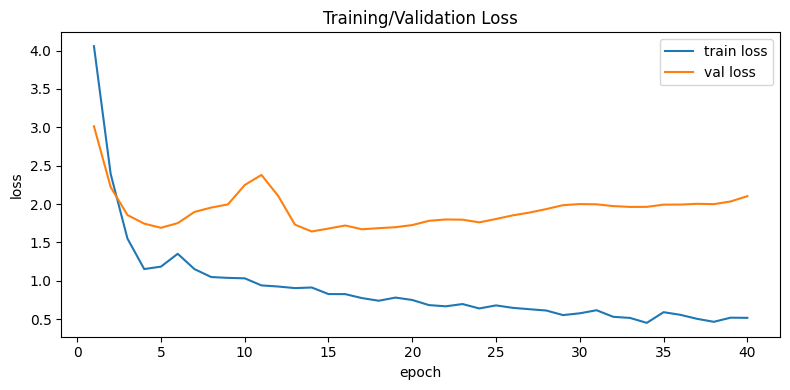

In [15]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(8, 4))
plt.plot(epochs, train_losses, label='train loss')
plt.plot(epochs, val_losses, label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training/Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()
